# Assignment 2

## Roll number: 2023121013, 2023122002, 2023121006


### Instructions
 * Fill in the roll-number in the cell above.
 * Code must be submitted in Python in jupyter notebooks. We highly recommend using anaconda/miniconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 *  Most of the questions require you to **code your own functions** unless there is a need to call in the abilities of the mentioned libraries, such as Visualisation from Open3D. Make sure your code is modular since you will be reusing them for future assignments. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 *  All the representations are expected to be in a right-hand coordinate system.
<!--  * Answer to the descriptive questions should be answered in your own words. Copy-paste answers will lead to penalty. -->
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit the notebooks in the repo and any other results files under the result folder in the GitHub Classroom repo. 
 * This is a group assignment. Discussions are encouraged but any sharing of code among different teams will be penalized. 

## SECTION 1: ICP with SVD

### 1.1 Perform Procrustes alignment on two point clouds with (given) known correspondences. (5 Points)

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2).

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

<b>Use root mean squared error (RSME) as the alignment error metric.</b>

Make sure your code is modular as we will use this function in the next sub-part.

We will again use our own getTransform function to generate the 4x4 Transformation matrix to transform the pointcloud to P2, so make sure your code works for any general Transformation matrix

In [1]:
# Imports

import math
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def getTransform():
    """ Generates a random 4x4 transformation matrix. """

    R = o3d.geometry.get_rotation_matrix_from_xyz(np.random.rand(3) * 2 * np.pi)
    T = np.random.rand(3) * 5000
    transformation = np.vstack((np.hstack((R, T.reshape(-1, 1))), [0, 0, 0, 1]))
    return transformation

In [3]:
def apply_transformation(points, transformation):
    """ Applies a 4x4 transformation matrix to an array of points. """

    rotation = transformation[:3, :3]
    translation = transformation[:3, 3]
    transformed_points = (points @ rotation.T) + translation
    return transformed_points

In [4]:
def icp_known_correspondences(T):
    """ Given a transformation matrix, transforms toothless.ply
    and recovers the transformation using Procrustes alignment."""

    # Read the point cloud
    pcd = o3d.io.read_point_cloud("data/toothless.ply")
    X_P1 = np.asarray(pcd.points)

    # Apply the transformation
    X_P2 = apply_transformation(X_P1, T)

    # Predict the applied transformation
    T_pred = procrustes_alignment(X_P1, X_P2)

    # Apply the predicted transformation
    X_P2_pred = apply_transformation(X_P1, T_pred)

    # Compute RMSE between the two transformed point clouds
    error = np.sqrt(np.mean((X_P2 - X_P2_pred) ** 2))

    return T_pred, error

def procrustes_alignment(P, Q):
    """ Performs Procrustes alignment on two point clouds
    and returns the transformation matrix."""

    # Compute the mean of the point clouds
    P_mean = np.mean(P, axis=0)
    Q_mean = np.mean(Q, axis=0)

    # Center the two point clouds around their means
    P_centered = P - P_mean
    Q_centered = Q - Q_mean

    # Compute the cross-covariance matrix
    W = Q_centered.T @ P_centered

    # Compute the SVD of the cross-covariance matrix
    U, S, V_t = np.linalg.svd(W)

    # Compute the rotation and translation
    R = U @ V_t
    T = Q_mean - (R @ P_mean)

    # Construct the transformation matrix
    transformation = np.vstack((np.hstack((R, T.reshape(-1, 1))), [0, 0, 0, 1]))

    return transformation

T = getTransform()
T_pred, alignment_error = icp_known_correspondences(T)
T_error = np.sqrt(np.mean((T_pred - T) ** 2))

print('Original Transformation:\n', T)
print('Predicted Transformation:\n', T_pred)
print('Alignment Error:', alignment_error)
print('Error in Transformation:', T_error)

Original Transformation:
 [[ 3.27409320e-01 -1.35705634e-01 -9.35086690e-01  7.96035799e+02]
 [ 7.98500400e-01 -4.89360509e-01  3.50604339e-01  2.90643619e+03]
 [-5.05173483e-01 -8.61458225e-01 -5.18601884e-02  2.89807172e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Predicted Transformation:
 [[ 3.27409320e-01 -1.35705634e-01 -9.35086690e-01  7.96035799e+02]
 [ 7.98500400e-01 -4.89360509e-01  3.50604339e-01  2.90643619e+03]
 [-5.05173483e-01 -8.61458225e-01 -5.18601884e-02  2.89807172e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Alignment Error: 4.116292489026618e-11
Error in Transformation: 1.782458165628076e-11


### 1.2 Implement ICP algorithm with unknown correspondences. (5 Points)

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration. 

Refer to Shubodh's notes to compute correspondences: https://saishubodh.notion.site/Mobile-Robotics-Navigating-from-Theory-to-Application-0b65a9c20edd4081978f4ffad917febb?p=a25686ce1a11409d838d47bcac43ab4b&pm=s#bb9aaf2e316b4db3b399df1742f0444c


In [5]:
def icp_unknown_correspondences(P, Q, num_iterations=15, visualization=True):
    """ Given two transformation matrices, transforms and shuffles toothless.ply
    and performs alignment on the transformed point clouds. """

    # Read the point cloud
    pcd = o3d.io.read_point_cloud("data/toothless.ply")
    X = np.asarray(pcd.points)

    # Apply the transformation
    X_P = apply_transformation(X, P)
    X_Q = apply_transformation(X, Q)

    # Shuffle the second point cloud for unknown correspondences
    np.random.shuffle(X_Q)

    # Visualize the point clouds
    if visualization:
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        PC_X_P = o3d.geometry.PointCloud()
        PC_X_Q = o3d.geometry.PointCloud()
        PC_X_P.points = o3d.utility.Vector3dVector(X_P)
        PC_X_Q.points = o3d.utility.Vector3dVector(X_Q)
        vis.add_geometry(PC_X_P)
        vis.add_geometry(PC_X_Q)
        vis.poll_events()
        vis.update_renderer()

    # Initialize the error and predicted transformation
    error = 0
    T_pred = np.eye(4)

    for iteration in range(num_iterations):
        # Subsample point clouds
        X_P_sampled = X_P[np.random.choice(X_P.shape[0], 1000, replace=False)]
        X_Q_sampled = X_Q[np.random.choice(X_Q.shape[0], 5000, replace=False)]

        # Determine corresponding pairs and align the sampled point cloud
        distance, indices = get_nearest_neighbors(X_P_sampled, X_Q_sampled)
        X_Q_sampled = X_Q_sampled[indices]

        # Predict the applied transformation
        T_pred_current = procrustes_alignment(X_P_sampled, X_Q_sampled)
        T_pred = T_pred_current @ T_pred

        # Apply the predicted transformation
        X_P = apply_transformation(X_P, T_pred_current)
        X_P_sampled = apply_transformation(X_P_sampled, T_pred_current)

        # Update the visualization
        if visualization:
            PC_X_P.points = o3d.utility.Vector3dVector(X_P)
            vis.update_geometry(PC_X_P)
            vis.poll_events()
            vis.update_renderer()

        # Compute RMSE between the two subsampled point clouds
        error = np.sqrt(np.mean((X_P_sampled - X_Q_sampled) ** 2))

    # Terminate visualization
    if visualization:
        vis.run()
        vis.destroy_window()

    return T_pred, error

def get_nearest_neighbors(P, Q):
    dist = np.linalg.norm(P[:, np.newaxis] - Q, axis=2)
    return np.min(dist, axis=1), np.argmin(dist, axis=1)

P = getTransform()
Q = getTransform()
Q_pred, alignment_error = icp_unknown_correspondences(P, Q)
Q_error = np.sqrt(np.mean((Q_pred - Q) ** 2))

print('Original Transformation:\n', Q)
print('Predicted Transformation:\n', Q_pred)
print('Alignment Error:', alignment_error)
print('Error in Transformation:', Q_error)

Original Transformation:
 [[-4.76142953e-01 -6.40359405e-01 -6.02683765e-01  1.90470303e+03]
 [-4.25778037e-01  7.67547723e-01 -4.79148782e-01  3.86995284e+03]
 [ 7.69415981e-01  2.84661942e-02 -6.38113410e-01  4.37413883e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Predicted Transformation:
 [[ 7.66411890e-01  2.66666391e-01 -5.84381596e-01  2.49568085e+02]
 [-6.19437760e-01  6.60107786e-02 -7.82265581e-01  8.55062094e+03]
 [ 1.70028455e-01 -9.61525669e-01 -2.15774678e-01  7.29645364e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Alignment Error: 18.555525134456627
Error in Transformation: 1440.226846712387


## SECTION 2: ICP with Lie Groups

### 2.1 Predict the Transformation matrix between 2 point clouds with known correspondences (15 Points)
Perform the same task as 1.1 using Lie Group Optimization from scratch to predict the transformation between the 2 point clouds.

Refer: https://saishubodh.notion.site/Mobile-Robotics-Navigating-from-Theory-to-Application-0b65a9c20edd4081978f4ffad917febb?p=ee55fe5689794693910ab7861bef067b&pm=s#7b82d84766a84b63b91d859579e4886b


In [6]:
def skew_symmetric(v):
    """ Convert a vector to a skew-symmetric matrix. """

    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def exponential_map(xi):
    """ Exponential map from the local tangent space to the group. """

    omega = xi[:3]
    v = xi[3:]

    theta = np.linalg.norm(omega)
    omega_hat = skew_symmetric(omega)
    R = np.eye(3)
    R += (np.sin(theta) / theta) * omega_hat
    R += ((1 - np.cos(theta)) / (theta * theta)) * (omega_hat @ omega_hat)

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = v
    return T

def icp_with_lie(T, max_iterations=50, tolerance=1e-6):
    """ Given a transformation matrix, transforms toothless.ply
    and recovers the transformation using Lie Group Optimization."""

    # Read the point cloud
    pcd = o3d.io.read_point_cloud("data/toothless.ply")
    X_P1 = np.asarray(pcd.points)

    # Apply the transformation
    X_P2 = apply_transformation(X_P1, T)

    # Add Gaussian noise to simulate practical scenarios
    num_points = X_P2.shape[0]
    X_P2 += 0.01 * np.random.randn(num_points, 3)

    # Predict the applied transformation
    T_pred = np.eye(4)
    for iteration in range(max_iterations):
        # Apply the current transformation
        X_P2_pred = apply_transformation(X_P1, T_pred)

        # Compute the residuals
        residuals = X_P2 - X_P2_pred

        # Compute the Jacobian matrix
        J = np.zeros((3 * num_points, 6))
        for idx in range(num_points):
            J[3*idx:3*idx+3, :3] = -skew_symmetric(X_P2_pred[idx])
            J[3*idx:3*idx+3, 3:] = np.eye(3)

        # Compute the update using Gauss-Newton method
        H = J.T @ J
        g = J.T @ residuals.flatten()
        delta_xi = np.linalg.solve(H, g)

        # Update the transformation
        delta_T = exponential_map(delta_xi)
        T_pred = delta_T @ T_pred

        # Check for convergence
        if np.linalg.norm(delta_xi) < tolerance:
            break

    # Apply the predicted transformation
    X_P2_pred = apply_transformation(X_P1, T_pred)

    # Compute RMSE between the two transformed point clouds
    error = np.sqrt(np.mean((X_P2 - X_P2_pred) ** 2))

    return T_pred, error

T = getTransform()
T_pred, alignment_error = icp_with_lie(T)
T_error = np.sqrt(np.mean((T_pred - T) ** 2))

print('Original Transformation:\n', T)
print('Predicted Transformation:\n', T_pred)
print('Alignment Error:', alignment_error)
print('Error in Transformation:', T_error)

Original Transformation:
 [[ 9.00236906e-01  4.23216127e-01  1.02282071e-01  4.19823763e+03]
 [ 5.89806804e-03 -2.46747035e-01  9.69061976e-01  4.76293072e+03]
 [ 4.35360454e-01 -8.71782089e-01 -2.24626945e-01  1.99778857e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Predicted Transformation:
 [[ 9.00237172e-01  4.23215573e-01  1.02282027e-01  4.19823764e+03]
 [ 5.89775983e-03 -2.46746630e-01  9.69062081e-01  4.76293073e+03]
 [ 4.35359910e-01 -8.71782472e-01 -2.24626512e-01  1.99778858e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Alignment Error: 0.00999633841898996
Error in Transformation: 5.0417104656567086e-06


## SECTION 3: Pose Graph Optimization with G2O
### Objective (5 Points)
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a pose graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

References:

1.) Class notes: https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3

2.) Cyrill Stachniss lecture: https://www.youtube.com/watch?v=uHbRKvD8TWg 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

Install g2o as mentioned in `g2o.ipynb` and optimise `edges.txt`

In [4]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

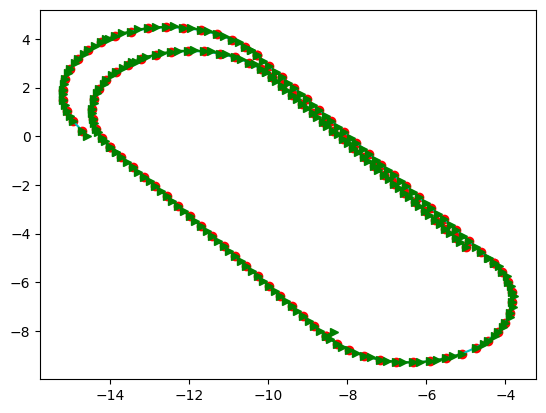

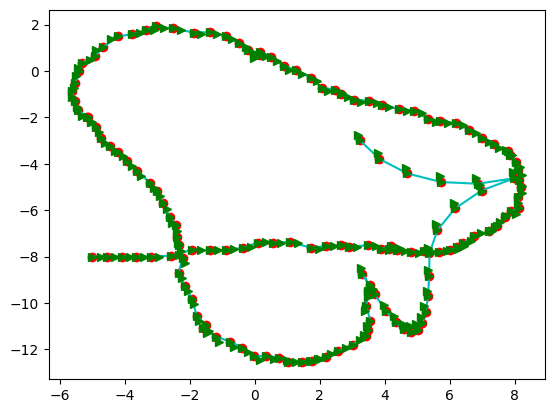

In [22]:
def relative_to_absolute(vertex, X, Y, THETA):
    """ Uses relative transformation between consecutive nodes to
    obtain absolute coordinates to track the trajectory of 2D motion. """

    X_motion = [ vertex[0], ]
    Y_motion = [ vertex[1], ]
    THETA_motion = [ vertex[2], ]

    for index in range(X.shape[0]):
        x = X_motion[-1] + (X[index] * math.cos(THETA_motion[-1])) - (Y[index] * math.sin(THETA_motion[-1]))
        y = Y_motion[-1] + (Y[index] * math.cos(THETA_motion[-1])) + (X[index] * math.sin(THETA_motion[-1]))
        theta = THETA_motion[-1] + THETA[index]

        X_motion.append(x)
        Y_motion.append(y)
        THETA_motion.append(theta)

    return X_motion, Y_motion, THETA_motion

vertex = readVertex('data/gt.txt')
ind1, ind2, X, Y, THETA = readEdge('data/gt.txt')
X_motion, Y_motion, THETA_motion = relative_to_absolute(vertex[0], X, Y, THETA)
draw(X_motion, Y_motion, THETA_motion)

vertex = readVertex('data/edges.txt')
ind1, ind2, X, Y, THETA = readEdge('data/edges.txt')
X_motion, Y_motion, THETA_motion = relative_to_absolute(vertex, X, Y, THETA)
draw(X_motion, Y_motion, THETA_motion)

### Evo (10 Points)
We need a measure of how good the trajectory is. The error/loss used earlier doesn't tell us much about how the trajectory differs from the ground truth. Here, we try to do just this - compute error metrics. Rather than computing these from scratch, we will just Evo - https://github.com/MichaelGrupp/evo/.

Look at the absolute pose error (APE) and relative pose error (RPE). What do they capture and how are they calculated (descriptive answer)? How do these metrics differ in methodology? Can we determine if the error is more along the x/y axis?

Answer the above questions and report errors for the obtained trajectory.

In [ ]:
### YOUR CODE HERE ###